### 3.2 Linear Regression Models and Least Squares
Given a vector of inputs, $X^T=(X_1, X_2, ..., X_p)$, we can predict an output value $Y$. The regression model has the form:
$$
f(X) = \beta_0 + \sum_{j=1}^{p}X_j \beta_j
$$
One method of estimating a linear regression model is ordinary least squares. An OLS regression selects the coefficient estimates $\beta=(\beta_0, \beta_1, ..., \beta_p)^T$ that minimize the residual sum of squares.
$$
RSS(\beta) = \sum_{i=1}^{N} (y_i - f(x_i))^2 = \sum_{i=1}^{N} \left( y_i - \beta_0 - \sum_{j=1}^{p} x_ij \beta_j \right)^2
$$
In matrix form this is.
$$
RSS(\beta) = (y - X \beta)^T (y - X \beta)
$$
To minimize the RSS we can differentiate this form and solve for the optimal $\beta$.
$$
\frac{dRSS(\beta)}{d\beta} = -2 X^T (y- X \beta) = 0
$$
We then have the unique solution for the OLS estimators.
$$
\hat{\beta} = (X^TX)^{-1} X^T y
$$

#### 3.2.1 Example: Prostate Cancer

In [148]:
# Import libraries.
import pandas as pd
import numpy as np
import scipy.stats
import math
import seaborn as sns


# Read data.
data = pd.read_table('prostate.txt')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(3)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T


<Axes: >

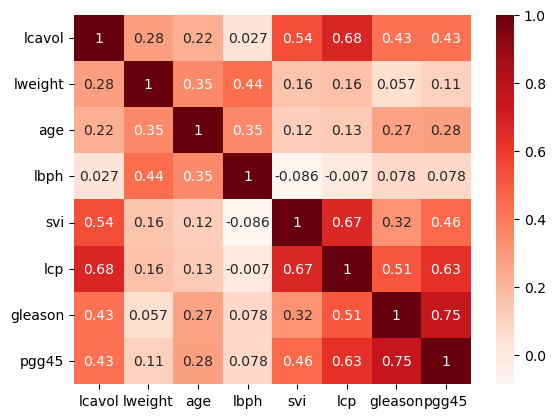

In [149]:
# Correlation of predictors.
corr = data[['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']].corr()
sns.heatmap(corr, annot=True, cmap='Reds')

In [150]:
# Grab train / test mask and target.
mask = data.pop('train')
y_ = data.pop('lpsa')


# Normalize predictors with zscores.
data = data.apply(scipy.stats.zscore)


# Select training data.
y_train = y_[mask == 'T']
X_train = data[mask == 'T']


# Insert intercept column.
X_train.insert(0, 'Intercept', 1)

In [180]:
class OLS:

    def __init__(self, X, y):
        # Input predictors and target.
        self.X = X
        self.y = y
        self.n = len(self.X)
        self.p = len(self.X.columns)

        # Outputs.
        self.beta = None
        self.y_hat = None
        self.res = None
        self.stderrs = None
        self.zscores = None

        # Summary dataframe.
        self.df = None


    # Function to get OLS estimates.
    def OLS(self):
        X, y = self.X.to_numpy(), self.y.to_numpy()
        self.beta = np.linalg.inv(X.T @ X) @ X.T @ y


    # Function to get predictions (y_hat)
    def predict(self):
        X, beta = self.X.to_numpy(), self.beta
        self.y_hat = X @ beta

    
    # Function to get residuals.
    def residuals(self):
        self.res = self.y - self.y_hat

    
    # Function to get s.e. of OLS coefficients.
    def ols_ses(self):
        X = self.X.to_numpy()
        sigma2 = sum(self.res ** 2) / (self.n - self.p)
        mat_xx = np.linalg.inv(X.T @ X)
        stderrs = [math.sqrt(mat_xx[j, j]*sigma2) for j in range(self.p)]
        self.stderrs = stderrs

    
    # Function to get Z-score of OLS coefficients.
    def OLS_z_scores(self):
        scores = self.beta / self.stderrs
        self.zscores = scores

    # Function to print summary results.
    def summarize(self):
        df = pd.DataFrame({
            'Term': self.X.columns,
            'Coefficient': np.round(self.beta, 2),
            'Std. Error': np.round(self.stderrs, 2),
            'Z Score': np.round(self.zscores, 2)
        })
        self.df = df
        print(df)


    # Function to fit model.
    def fit(self):

        # Get OLS estimates.
        self.OLS()

        # Get predicted values.
        self.predict()

        # Get residuals.
        self.residuals()

        # Get standard errors.
        self.ols_ses()

        # Get zscores.
        self.OLS_z_scores()

In [181]:
model_OLS = OLS(X_train, y_train)
model_OLS.fit()
model_OLS.summarize()

        Term  Coefficient  Std. Error  Z Score
0  Intercept         2.46        0.09    27.60
1     lcavol         0.68        0.13     5.37
2    lweight         0.26        0.10     2.75
3        age        -0.14        0.10    -1.40
4       lbph         0.21        0.10     2.06
5        svi         0.30        0.12     2.47
6        lcp        -0.29        0.15    -1.87
7    gleason        -0.02        0.14    -0.15
8      pgg45         0.27        0.15     1.74
